
Analyzing the relationship between the neural firing rates and search times to determine whether KL divergence or L1 distance better predicts perception
and whether search delays follows a distribution, more specifically, gamma distribution.


## **Monkey neurons, human search times—Can `math` crack the oddball** *mystery?*

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress

# 1. a

In [4]:
# The first three rows are used as headers (as they are just labels), forming a MultiIndex

search_data = pd.read_csv('search-times-dataset.csv', header=[0, 1, 2])

In [5]:
search_data.head()

Set 1                                                       Set 2  \
     Colour             Pattern             Chevron                 Far   
  Oddball L Oddball R Oddball L Oddball R Oddball L Oddball R Oddball L   
0       375      5025       771      1319       485       501       607   
1      1425      1146      1490      1149       554       655       653   
2      2088      1540      1532      1431       820       932       707   
3       875      1422       994       542       875      1263       600   
4      1373      1646      1590      1160       490       658       875   

                                                        Set 3            \
               Middle                Near               Small             
  Oddball R Oddball L Oddball R Oddball L Oddball R Oddball L Oddball R   
0       826       767       602       545       710      1257       655   
1      1210       546       766       490       548       880       719   
2       710       545       879       431       435       981       550   
3      1260       765      1434       607       655      1046       600   
4       715      1651       820       600       710      1536      1211   

                                           
     Medium               Large            
  Oddball L Oddball R Oddball L Oddball R  
0       547       494       499       495  
1       655       820       605       497  
2       658       710       438       495  
3       601       988      1100       662  
4       600      1147       714       825

In [6]:
# Subtracting the base reaction time : 328 ms to analyze relative differences
clean_search_data = search_data - 328

In [7]:
# clean_search_data

In [8]:
# Computing the column-wise mean
average_search_delays = clean_search_data.mean()

In [9]:
# Converting into a NumPy array
average_search_delays = average_search_delays.to_numpy()

In [10]:
average_search_delays

array([ 883.77777778, 1081.40277778,  985.25      , 1009.13888889,
        275.26388889,  296.66666667,  503.31944444,  502.79166667,
        313.40277778,  307.52777778,  218.55555556,  251.95833333,
        818.33333333,  615.23611111,  309.40277778,  341.93055556,
        239.84722222,  209.38888889])

# 1. b & c

In [11]:
# Load dataset with hierarchial headers (3-level column index)
# "brain_fire" represents neuron spikes
brain_fire = pd.read_csv('firing-rates-dataset.csv', header=[0, 1, 2])

In [12]:
# To verify
brain_fire.head()

Set 1                                                        Set 2  \
      Colour               Pattern               Chevron              Far   
           L          R          L          R          L          R     L   
0  24.000000  21.230769  44.615385  38.666667  25.538462  38.000000  10.0   
1  25.538462  11.692308  30.769231  19.000000  16.615385  23.666667  29.0   
2   2.333333   5.000000   5.666667   5.000000  11.666667  13.333333  17.0   
3  41.666667  53.000000  43.333333  39.000000  43.000000  48.333333  15.0   
4  18.000000  21.666667  27.333333  17.666667  16.000000  23.333333  13.0   

                                                              Set 3  \
                 Middle                  Near                 Small   
           R          L          R          L          R          L   
0  21.333333   5.333333  28.666667   4.333333  29.000000  26.333333   
1  35.333333  15.333333  37.333333  17.666667  37.333333  33.666667   
2  14.333333  14.333333  19.000000  11.333333  16.000000  20.666667   
3  17.666667  16.000000  15.000000  13.666667  15.000000  28.333333   
4  11.333333  10.666667  20.333333  14.000000  15.666667  30.000000   

                                                          
                 Medium                 Large             
           R          L          R          L          R  
0  46.666667  20.666667  50.769231  21.666667  40.333333  
1  29.333333  16.000000  20.000000  17.333333  19.333333  
2  17.333333  14.333333  16.666667  10.333333  13.666667  
3  16.333333  15.333333  26.666667  21.333333  25.333333  
4  27.333333  20.000000  28.333333  21.666667  34.000000

In [13]:
# Extract unique "Set" names from MultiIndex columns (avoiding repetition)

sets = brain_fire.columns.get_level_values(0).unique()

In [29]:
# To Debug
brain_fire.columns

MultiIndex([('Set 1',  'Colour', 'L'),
            ('Set 1',  'Colour', 'R'),
            ('Set 1', 'Pattern', 'L'),
            ('Set 1', 'Pattern', 'R'),
            ('Set 1', 'Chevron', 'L'),
            ('Set 1', 'Chevron', 'R'),
            ('Set 2',     'Far', 'L'),
            ('Set 2',     'Far', 'R'),
            ('Set 2',  'Middle', 'L'),
            ('Set 2',  'Middle', 'R'),
            ('Set 2',    'Near', 'L'),
            ('Set 2',    'Near', 'R'),
            ('Set 3',   'Small', 'L'),
            ('Set 3',   'Small', 'R'),
            ('Set 3',  'Medium', 'L'),
            ('Set 3',  'Medium', 'R'),
            ('Set 3',   'Large', 'L'),
            ('Set 3',   'Large', 'R')],
           )

In [36]:

# Small (Laplace) smoothing factor to prevent division by zero
epsilon = 1e-10  

# Function to compute KL divergence (relative entropy)
def relative_entropy(lambda_i, lambda_j):
    """
    Computes the KL(Kullback-Leibler) divergence between two neuronal firing rate distributions.

    KL divergence measures how much information is lost when λ_j approximates λ_i.
    renders KL divergence (relative entropy).
"""
    
    lambda_i, lambda_j = np.array(lambda_i), np.array(lambda_j)

    # Mask to filter out rows where either λ_i or λ_j is zero
    mask = (lambda_i > 0) & (lambda_j > 0)
    
    lambda_i_filtered = lambda_i[mask] + epsilon
    lambda_j_filtered = lambda_j[mask] + epsilon

    # Compute KL divergence: D(λ_i || λ_j)
    return np.mean(lambda_i_filtered * np.log(lambda_i_filtered / lambda_j_filtered) - lambda_i_filtered + lambda_j_filtered)


In [37]:
def l1_distance(lambda_i, lambda_j):
    """
    l1 distance while ignoring NaNs.
    """
    lambda_i, lambda_j = np.array(lambda_i), np.array(lambda_j)

    # Ignore rows where either λ_i or λ_j is NaN
    mask = ~np.isnan(lambda_i) & ~np.isnan(lambda_j)  # Keep only valid values
    lambda_i, lambda_j = lambda_i[mask], lambda_j[mask]

    return np.mean(np.abs(lambda_i - lambda_j))

In [38]:
# Initialize lists to store computed distances

# Stores KL divergence values
relative_entropy_distances = [] 

# Stores L1 distance values
L_1_distances = []

In [39]:
## Expected order of image pair types (formerly 'conditions') within each "Set"
odd_duos = ['Colour', 'Pattern', 'Chevron', 'Far', 'Middle', 'Near', 'Small', 'Medium', 'Large']

for set_name in sorted(sets):  
    if set_name in brain_fire.columns.levels[0]:  
        for oddball in odd_duos:
            if (set_name, oddball, 'L') in brain_fire.columns and (set_name, oddball, 'R') in brain_fire.columns:
                lambda_L = brain_fire[(set_name, oddball, 'L')].values
                lambda_R = brain_fire[(set_name, oddball, 'R')].values

                # Compute relative entropy (KL divergence)
                
                # Considering λ_L as an oddball image and λ_R as a distractor image
                D_ij = relative_entropy(lambda_L, lambda_R)  # D (L || R)

                # Considering λ_R as an oddball image and λ__L as a distractor image
                D_ji = relative_entropy(lambda_R, lambda_L)  # D (R || L)

                # Store KL divergence results
                relative_entropy_distances.append(D_ij)
                relative_entropy_distances.append(D_ji)

                # Computing and storing L1 distances
                L_ij = l1_distance(lambda_L, lambda_R)
                L_ji = l1_distance(lambda_R, lambda_L) # L_ij == L_ji since |a - b| == |b - a|

                L_1_distances.append(L_ij)
                L_1_distances.append(L_ji)
             

# Converting into NumPy arrays
relative_entropy_distances = np.array(relative_entropy_distances)
L_1_distances = np.array(L_1_distances)

In [40]:
relative_entropy_distances

array([0.63834794, 0.61835705, 0.65685051, 0.66293651, 1.55337325,
       1.63076479, 1.11677337, 1.09011194, 1.46193832, 1.56548597,
       1.77473095, 2.12783769, 0.65428099, 0.78416525, 1.13060613,
       1.47729041, 1.64344117, 1.72498623])

In [41]:
L_1_distances

array([2.7756785 , 2.7756785 , 3.20633068, 3.20633068, 4.79391394,
       4.79391394, 3.79158273, 3.79158273, 4.13455124, 4.13455124,
       4.72969894, 4.72969894, 3.11108657, 3.11108657, 3.94509803,
       3.94509803, 5.45929509, 5.45929509])

##  What Do These Numbers Mean in Neuronal Response  

- **If either KL divergence or L1 distance is large**, it means the neuron responds **very differently** to oddballs than to distractors. **The brain detects the oddball!**  
- **If either KL divergence or L1 distance is small**, neurons are treating the oddball **similarly** to a distractor **The brain isn’t reacting much.**  


# 2. a

### Why is the best-fit slope computed as Σ(xy) / Σ(x²)?

We minimize the **Mean Squared Error (MSE)** to find the best-fit slope `m` in `y = mx`:

MSE = (1/N) Σ (yᵢ - m xᵢ)²  

A function reaches its **minimum** when its **derivative is zero**:

d/dm (MSE) = 0  

This ensures the function stops decreasing and starts increasing (**turning point**).  

---  

For **least squares regression**, the function to minimize is:

S(m) = Σ (yᵢ - m xᵢ)²  

Taking the derivative:

d/dm [Σ (yᵢ - m xᵢ)²] = -2 Σ xᵢ yᵢ + 2m Σ xᵢ²  

Setting it to zero:

Σ xᵢ yᵢ = m Σ xᵢ²  

Solving for `m`:

m = Σ (xᵢ yᵢ) / Σ (xᵢ²)  

---

In [42]:
metric_entropy = np.array(relative_entropy_distances) # X-axis KL divergence (perceptual distance)
inv_search_time = 1 / np.array(average_search_delays) # Y-axis: Inverse of average search delays

# Ensures dimensions match by averaging adjacent pairs
if len(inv_search_time) > len(metric_entropy):
    inv_search_time = np.mean(inv_search_time.reshape(-1, 2), axis=1)

# optimal slope for the best-fit line passing through the origin
m_opt_entropy = np.sum(metric_entropy * inv_search_time) / np.sum(metric_entropy ** 2)

print(f"Optimal slope for KL divergence : {m_opt_entropy:.6f}")

Optimal slope for KL divergence : 0.002202


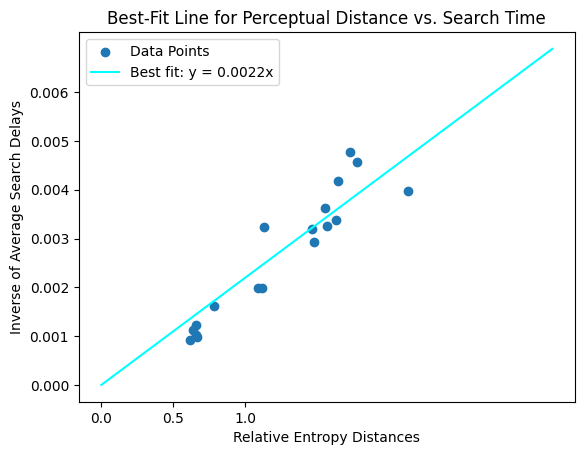

In [60]:
# Generate x values for plotting the best-fit line
x_line = np.linspace(0, max(metric_entropy) + 1, 100)

# Plotting
plt.scatter(metric_entropy, inv_search_time, label="Data Points")
plt.plot(x_line, m_opt_entropy * x_line, color="cyan", label=f"Best fit: y = {m_opt_entropy:.4f}x")
plt.xticks(np.arange(0, 1.10, 0.50))
plt.yticks(np.arange(0, 0.007, 0.001))
plt.xlabel("Relative Entropy Distances")
plt.ylabel("Inverse of Average Search Delays")
plt.legend()
plt.title("Best-Fit Line for Perceptual Distance vs. Search Time")
plt.show()

# 2. b

In [44]:
L1_perceptual_distance = np.array(L_1_distances)

if len(inv_search_time) > len(L1_perceptual_distance):
    inv_search_time = np.mean(inv_search_time.reshape(-1, 2), axis=1)

# Optimal slope for L1 distances
m_opt_L1 = np.sum(L1_perceptual_distance * inv_search_time) / np.sum(L1_perceptual_distance**2)

print(f"Optimal slope for L1 distances : {m_opt_L1:.6f}")

Optimal slope for L1 distances : 0.000700


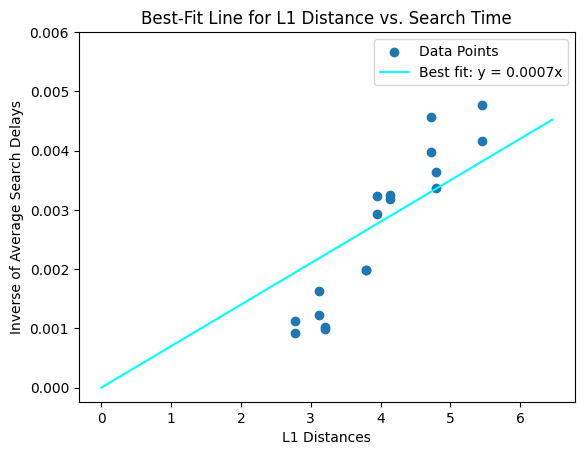

In [45]:
x_line = np.linspace(0, max(L1_perceptual_distance) + 1, 100)

plt.scatter(L1_perceptual_distance, inv_search_time, label="Data Points")
plt.plot(x_line, m_opt_L1 * x_line, color="cyan", label=f"Best fit: y = {m_opt_L1:.4f}x")
plt.xticks(np.arange(0, 7.0, 1.0))
plt.yticks(np.arange(0, 0.007, 0.001))
plt.xlabel("L1 Distances")
plt.ylabel("Inverse of Average Search Delays")
plt.legend()
plt.title("Best-Fit Line for L1 Distance vs. Search Time")
plt.show()

# Which model fits better? 
# **Let the MSE decide!**

In [46]:
# Computing predicted values for both models
predicted_inv_search_entropy = m_opt_entropy * metric_entropy
predicted_inv_search_L1 = m_opt_L1 * L1_perceptual_distance

# Mean Squared Error (MSE) for both models
# MSE = 𝟏/𝑁 Σ (𝑦_actual - 𝑦_predicted)²

mse_entropy = np.mean((inv_search_time - predicted_inv_search_entropy) ** 2)
mse_L1 = np.mean((inv_search_time - predicted_inv_search_L1) ** 2)

# Determining which model is better
if mse_entropy < mse_L1:
    print("KL divergence is a better fit (lower MSE).")
else:
    print("L1 distance is a better fit (lower MSE).")

KL divergence is a better fit (lower MSE).


# 3. a

Estimated Shape Parameter (a): 2.3476
Estimated Shape Parameter (From Plot Slope): 0.6325


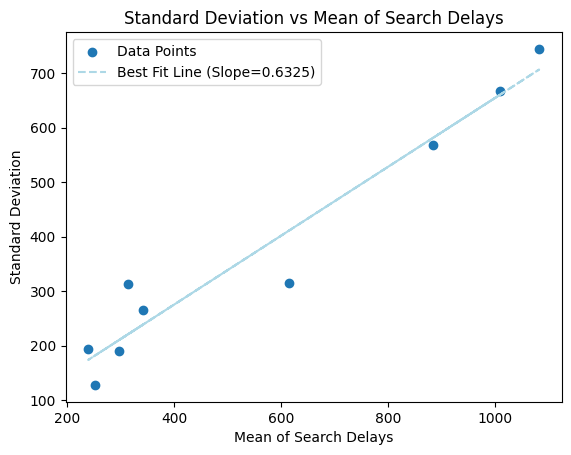

In [47]:
# Computing shape parameter

np.random.seed(42)
num_cols = clean_search_data.shape[1]

# Select half of the columns randomly
selected_columns = np.random.choice(clean_search_data.columns, size=num_cols // 2, replace=False)

# means and standard deviations for selected columns
mean_search_delays = clean_search_data[selected_columns].mean().values
std_search_delays = clean_search_data[selected_columns].std().values

# a = (mean / std)² (derived from Gamma distribution properties)
shape_param = np.mean((mean_search_delays / std_search_delays) ** 2)
print(f"Estimated Shape Parameter (a): {shape_param:.4f}")


# Fit a straight line to the data (std = slope * mean)
slope, intercept, _, _, _ = linregress(mean_search_delays, std_search_delays)

# Since std ≈ mean / sqrt(a), we rearrange to estimate a:
# a = (1/slope)²shape_param_from_plot = (1 / slope) ** 2
print(f"Estimated Shape Parameter (From Plot Slope): {slope:.4f}")

# Plot standard deviation vs. mean with best-fit line
plt.scatter(mean_search_delays, std_search_delays, label="Data Points")

# Optional
plt.plot(mean_search_delays, slope * mean_search_delays + intercept, color="lightblue",linestyle="--", label=f"Best Fit Line (Slope={slope:.4f})")

plt.xlabel("Mean of Search Delays")
plt.ylabel("Standard Deviation")
plt.title("Standard Deviation vs Mean of Search Delays")
plt.legend()
plt.show()

# 3. b

In [48]:
# Estimating rate parameter (b)
remaining_columns = clean_search_data.columns.difference(selected_columns)  # More robust selection
remaining_data = clean_search_data[remaining_columns]

# Remove NaN values before sampling
remaining_data = remaining_data.dropna()

# Ensures there are enough samples
if remaining_data.empty:
    print("Warning: No remaining data available after cleaning.")
    rate_param = np.nan
else:
    # Select half of the rows randomly from remaining columns
    selected_samples = remaining_data.sample(frac=0.5, random_state=42, axis=0)

    # mean and standard deviation
    mean_selected_samples = selected_samples.mean().mean()
    std_selected_samples = selected_samples.std().mean()

    # Handle zero standard deviation case
    # b = μ / σ² ( mean / standard_deviation² )
    rate_param = np.nan if std_selected_samples == 0 else mean_selected_samples / (std_selected_samples ** 2)

print(f"Estimated Rate Parameter (b): {rate_param:.4f}")


Estimated Rate Parameter (b): 0.0056


# 3. c

Kolmogorov-Smirnov Test Statistic: 0.1437


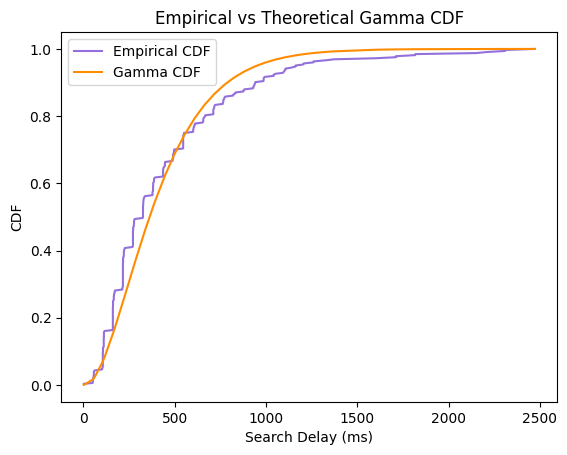

In [49]:
# Computing empirical CDF and comparing with Gamma CDF using the remaining half of data

remaining_samples = remaining_data.drop(selected_samples.index)  # The other half (1/4 of total)

# Converts remaining samples to a 1D array
search_delays = remaining_samples.values.flatten()

# Sort the data foe CDF calculation
search_delays = np.sort(search_delays)

# F_empirical(x_i) = (Rank of x_i) / Total samples (N)
# np.arange(1, N+1) generates ranks [1, 2, ..., N]
# Dividing by N ensures normalization (last value reaches 1) (basically probabilities)

empirical_cdf = np.arange(1, len(search_delays) + 1) / len(search_delays)  

# Computing Gamma CDF using estimated a and b
gamma_cdf = stats.gamma.cdf(search_delays, a=shape_param, scale=1/rate_param)

# --- Computing Kolmogorov-Smirnov test statistic ---
# KS = max | CDF_empirical(x) - CDF_gamma(x) |
ks_stat = np.max(np.abs(empirical_cdf - gamma_cdf))
print(f"Kolmogorov-Smirnov Test Statistic: {ks_stat:.4f}")

# Plotting empirical CDF vs. Gamma CDF
plt.plot(search_delays, empirical_cdf, label="Empirical CDF", color="mediumpurple")
plt.plot(search_delays, gamma_cdf, label="Gamma CDF", color="darkorange")
plt.xlabel("Search Delay (ms)")
plt.ylabel("CDF")
plt.legend()
plt.title("Empirical vs Theoretical Gamma CDF")
plt.show()